# SC3000 lab assignment:
**Group member: Pham Ba Cong - U2331760J**

### Step 1: Install necesscary packages

In [1]:
!pip install matplotlib
!pip install torch numpy transformers datasets tiktoken wandb tqdm

/bin/bash: line 1: pip: command not found
/bin/bash: line 1: pip: command not found


### Step 2: Package imports and configuration

In [2]:
import sys
import os
sys.path.append(os.path.abspath("/home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math")) 
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
import pickle
from model import GPT, GPTConfig
import random
from tqdm import tqdm
import time
import json
import matplotlib.pyplot as plt
# Configuration
beta = 0.5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
base_lr = 1e-4
epochs = 40
batch_size = 1024
max_length =64
num_samples = 1
max_new_tokens = 128
temperature = 0.8
top_k = 200
checkpoint_path = "/home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/"
os.makedirs(checkpoint_path, exist_ok=True)
# tokenizer
with open("/home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/sft/meta.pkl", "rb") as f:
    meta = pickle.load(f)
stoi, itos = meta["stoi"], meta["itos"]
def encode(s): return [stoi[c] for c in s]
def decode(l): return ''.join([itos[i] for i in l])

### Step 3: Define helper functions

In [3]:
def compute_logprob(input_ids):
    inputs = input_ids[:, :-1]
    targets = input_ids[:, 1:]
    logits, _ = gpt(inputs, full_seq=True)
    B, T, V = logits.size()
    logits_flat = logits.reshape(-1, V)
    targets_flat = targets.reshape(-1)
    loss = F.cross_entropy(logits_flat, targets_flat, ignore_index=0, reduction='none')
    loss = loss.reshape(B, T)
    attention_mask = (targets != 0).float()
    loss = (loss * attention_mask).sum(dim=1) / attention_mask.sum(dim=1)
    return -loss 

def pad_or_truncate(seq, max_length):
    return seq[-max_length:] if len(seq) > max_length else seq + [0] * (max_length - len(seq))

def get_batches(lines, batch_size):
    random.shuffle(lines)
    #for l in lines:
    #    print(l[1])
    for i in range(0, len(lines), batch_size):
        batch = lines[i:i+batch_size]
        if len(batch) < batch_size:
            continue
        neg_inputs = [pad_or_truncate(encode(p['negative'] + '\n\n\n\n'), max_length) for p in batch]
        pos_inputs = [pad_or_truncate(encode(p['positive'] + '\n\n\n\n'), max_length) for p in batch]
        neg_tensor = torch.tensor(neg_inputs, dtype=torch.long, device=device)
        pos_tensor = torch.tensor(pos_inputs, dtype=torch.long, device=device)
        yield neg_tensor, pos_tensor

### Step 4: Load the pretrained NanoGPT model

In [4]:
ckpt = torch.load("/home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/sft/gpt.pt", map_location=device)
gptconf = GPTConfig(**ckpt['model_args'])
gpt = GPT(gptconf)
state_dict = ckpt['model']
unwanted_prefix = '_orig_mod.'
for k in list(state_dict.keys()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
gpt.load_state_dict(state_dict)
gpt.to(device).train()

GPT(
  (transformer): ModuleDict(
    (wte): Embedding(74, 348)
    (wpe): Embedding(256, 348)
    (drop): Dropout(p=0.2, inplace=False)
    (h): ModuleList(
      (0-5): 6 x Block(
        (ln_1): LayerNorm()
        (attn): CausalSelfAttention(
          (c_attn): Linear(in_features=348, out_features=1044, bias=False)
          (c_proj): Linear(in_features=348, out_features=348, bias=False)
          (attn_dropout): Dropout(p=0.2, inplace=False)
          (resid_dropout): Dropout(p=0.2, inplace=False)
        )
        (ln_2): LayerNorm()
        (mlp): MLP(
          (c_fc): Linear(in_features=348, out_features=1392, bias=False)
          (gelu): GELU(approximate='none')
          (c_proj): Linear(in_features=1392, out_features=348, bias=False)
          (dropout): Dropout(p=0.2, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm()
  )
  (lm_head): Linear(in_features=348, out_features=74, bias=False)
)

### Step 5: Load Data (**students are required to complete this part!**)

In [5]:
# Load data from ./data/pos_neg_pairs.json
with open("/home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/data/dpo_data.json", "r") as f:
    lines = [json.loads(line) for line in f]
print(len(lines))

400004


### Step 6: Build the optimizer and scheduler (**students are required to complete this part!**)

In [6]:
# recommend to use the AdamW optimizer 
total_steps = len(lines) // batch_size
optimizer = torch.optim.AdamW(gpt.parameters(), lr=base_lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=total_steps)

### Step 7: Begin training

We will train the model with the dpo algorithm, i tested some epochs and found that the loss converges and the model perform well at around 35-40 epochs, so we will train the model for max 40 epochs i have also added early stopping to save some time and prevent overfitting

In [7]:
from tqdm import tqdm
import re

We first define a validation function for performance tracking during training

In [8]:
with open("/home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/data/dpo_test_data.json", "r") as f:
    val_data = f.readlines()
    val_data = [json.loads(line) for line in val_data]
print(len(val_data))

404


In [9]:
def validate(model, val_data):
    model.eval()
    
    total_correct = 0
    total_questions = 0
    
    with torch.no_grad():
        for sample in tqdm(val_data, desc="Running validation"):
            question = sample['question']
            gt = sample['answer']
            
            prompt_ids = encode(question)
            x = torch.tensor(prompt_ids, dtype=torch.long, device=device).unsqueeze(0)
            generated_ids, _ = model.generate(x, max_new_tokens, temperature=0.2, top_k=top_k)
            output = decode(generated_ids[0].tolist())
            
            pattern = r'The answer is (-?\d+)'
            match = re.search(pattern, output)

            if match is None:
                predicted_answer = None
            else:
                predicted_answer = int(match.group(1))
                
            is_correct = (predicted_answer == gt)
            
            total_questions += 1
            if is_correct:
                total_correct += 1
    
    overall_acc = total_correct / total_questions if total_questions > 0 else 0.0
    
    results = {
        'accuracy': overall_acc,
        'total_correct': total_correct,
        'total_questions': total_questions
    }
    
    return results

In [10]:
total_steps = len(lines) // batch_size
loss_list = []
accuracy_list = []
best_loss = float('inf')
patience = 0
patience_threshold = 10 #early stop if loss doesn't improve for 10 epochs

for epoch in range(epochs):
    epoch_losses = []  # Track losses for this epoch
    
    pbar = tqdm(get_batches(lines, batch_size), total=total_steps, desc=f"Training")
    for step, (neg_tensor,pos_tensor) in enumerate(pbar):
        optimizer.zero_grad()
        neg_logprob = compute_logprob(neg_tensor)
        pos_logprob = compute_logprob(pos_tensor)
        loss = -F.logsigmoid((pos_logprob - neg_logprob) / beta).mean() - pos_logprob.mean() * 0.1 
        loss.backward()
        optimizer.step()
        scheduler.step()
        pbar.update(1)
        epoch_losses.append(loss.item())
    
    # Calculate average epoch loss
    avg_epoch_loss = sum(epoch_losses) / len(epoch_losses)
    loss_list.append(avg_epoch_loss)
    
    # Early stopping check (after epoch completes)
    if avg_epoch_loss < best_loss:
        best_loss = avg_epoch_loss
        patience = 0
    else:
        patience += 1
        if patience >= patience_threshold:
            print(f"Early stopping at epoch {epoch}")
            break
    
    val_results = validate(gpt, val_data)
    accuracy_list.append(val_results['accuracy'])
    print(f"Epoch {epoch}, Loss: {avg_epoch_loss}, Accuracy: {val_results['accuracy']}")

    ckpt_path = checkpoint_path + f"dpo_{epoch}.pt"
    
    checkpoints = os.listdir(checkpoint_path)
    if len(checkpoints) > 5:
        checkpoints = [os.path.join(checkpoint_path, checkpoint) for checkpoint in checkpoints]
        checkpoints_sorted = sorted(checkpoints, key=os.path.getmtime)
        os.remove(checkpoints_sorted[0])

    torch.save({
            "model": gpt.state_dict(),
            "model_args": ckpt["model_args"],
            "optimizer": optimizer.state_dict(),
            "scheduler": scheduler.state_dict(),
        }, ckpt_path)
    print(f"Saved checkpoint to {ckpt_path}")

Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:24<00:00, 16.76it/s]


Epoch 0, Loss: 0.1904678907340918, Accuracy: 0.08663366336633663
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_0.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.84it/s]


Epoch 1, Loss: 0.07135109258576845, Accuracy: 0.0891089108910891
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_1.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.80it/s]


Epoch 2, Loss: 0.048272505440773106, Accuracy: 0.11386138613861387
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_2.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.75it/s]


Epoch 3, Loss: 0.04051659690359464, Accuracy: 0.15841584158415842
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_3.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.78it/s]


Epoch 4, Loss: 0.026197318169168936, Accuracy: 0.2301980198019802
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_4.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.69it/s]


Epoch 5, Loss: 0.026339358721788112, Accuracy: 0.19306930693069307
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_5.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.76it/s]


Epoch 6, Loss: 0.02304497187813887, Accuracy: 0.400990099009901
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_6.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.85it/s]


Epoch 7, Loss: 0.021850752940353674, Accuracy: 0.4628712871287129
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_7.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.74it/s]


Epoch 8, Loss: 0.020427391830927285, Accuracy: 0.556930693069307
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_8.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.79it/s]


Epoch 9, Loss: 0.02009715871551098, Accuracy: 0.5544554455445545
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_9.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.77it/s]


Epoch 10, Loss: 0.01919193552950254, Accuracy: 0.6138613861386139
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_10.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.77it/s]


Epoch 11, Loss: 0.021027764630241273, Accuracy: 0.4975247524752475
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_11.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.78it/s]


Epoch 12, Loss: 0.01865533810490981, Accuracy: 0.7202970297029703
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_12.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.74it/s]


Epoch 13, Loss: 0.018176023748058538, Accuracy: 0.7475247524752475
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_13.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.78it/s]


Epoch 14, Loss: 0.0174048931696094, Accuracy: 0.8267326732673267
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_14.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.76it/s]


Epoch 15, Loss: 0.017267045421669118, Accuracy: 0.7945544554455446
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_15.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.84it/s]


Epoch 16, Loss: 0.016698047657234545, Accuracy: 0.9232673267326733
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_16.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.83it/s]


Epoch 17, Loss: 0.01653926793772441, Accuracy: 0.8960396039603961
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_17.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.77it/s]


Epoch 18, Loss: 0.016241037062345406, Accuracy: 0.9579207920792079
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_18.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.80it/s]


Epoch 19, Loss: 0.016213797056713164, Accuracy: 0.9282178217821783
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_19.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.75it/s]


Epoch 20, Loss: 0.016068886822232835, Accuracy: 0.9702970297029703
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_20.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.88it/s]


Epoch 21, Loss: 0.016047339759862576, Accuracy: 0.8886138613861386
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_21.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.84it/s]


Epoch 22, Loss: 0.023384473515817752, Accuracy: 0.8663366336633663
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_22.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.81it/s]


Epoch 23, Loss: 0.01679435300712402, Accuracy: 0.943069306930693
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_23.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.87it/s]


Epoch 24, Loss: 0.016042976112415393, Accuracy: 0.9777227722772277
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_24.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.78it/s]


Epoch 25, Loss: 0.01599324357528717, Accuracy: 0.9628712871287128
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_25.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.82it/s]


Epoch 26, Loss: 0.01590262346733839, Accuracy: 0.9925742574257426
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_26.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.78it/s]


Epoch 27, Loss: 0.01591638750038468, Accuracy: 0.9653465346534653
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_27.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.82it/s]


Epoch 28, Loss: 0.0158507743348869, Accuracy: 1.0
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_28.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.80it/s]


Epoch 29, Loss: 0.01587634494002813, Accuracy: 0.9702970297029703
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_29.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.86it/s]


Epoch 30, Loss: 0.01581055543695887, Accuracy: 1.0
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_30.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.79it/s]


Epoch 31, Loss: 0.01579142550054269, Accuracy: 0.9752475247524752
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_31.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.77it/s]


Epoch 32, Loss: 0.01580121994782717, Accuracy: 1.0
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_32.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.78it/s]


Epoch 33, Loss: 0.017938325895617405, Accuracy: 0.6410891089108911
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_33.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.80it/s]


Epoch 34, Loss: 0.01603159472011985, Accuracy: 0.9975247524752475
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_34.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.83it/s]


Epoch 35, Loss: 0.015836701169610022, Accuracy: 0.9826732673267327
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_35.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.76it/s]


Epoch 36, Loss: 0.015768122336325737, Accuracy: 1.0
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_36.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.86it/s]


Epoch 37, Loss: 0.015774782427037375, Accuracy: 0.9851485148514851
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_37.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.81it/s]


Epoch 38, Loss: 0.01575671382105121, Accuracy: 1.0
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_38.pt


Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.86it/s]


Epoch 39, Loss: 0.01576793011612235, Accuracy: 0.9752475247524752
Saved checkpoint to /home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_39.pt


Now let's plot the loss and accuraccy curves to see how the training went

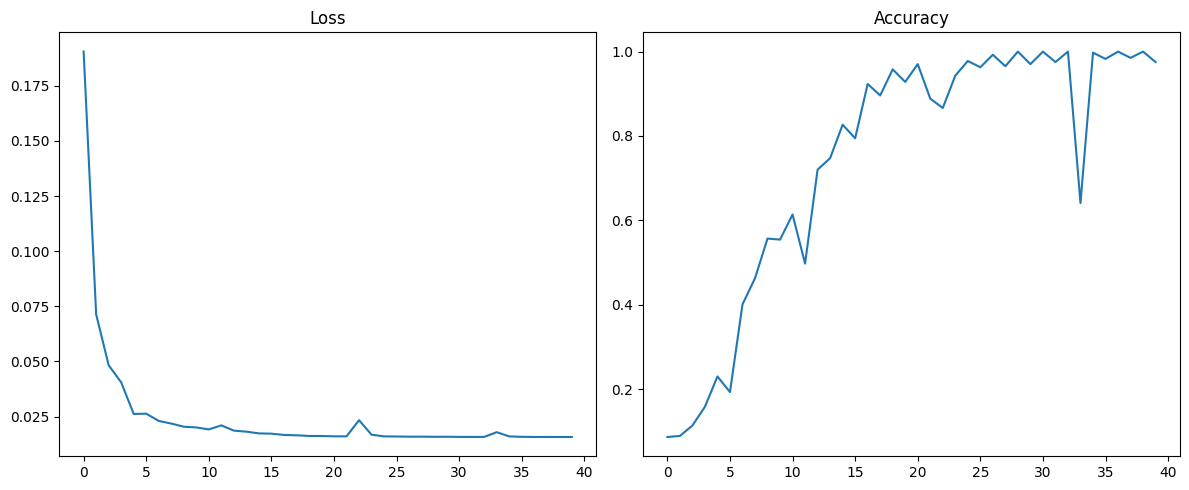

In [11]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].plot(loss_list)
axes[0].set_title('Loss')
axes[1].plot(accuracy_list)
axes[1].set_title('Accuracy')
plt.tight_layout()
plt.show()

### Step 8: Begin testing (**students are required to complete this part!**)

Test with some of the given examples, we will test on our test set after this

In [16]:
# Load the fine-tuned model
ckpt_path = "/home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/checkpoints/dpo/dpo_38.pt"
checkpoint = torch.load(ckpt_path, map_location=device)
gptconf = GPTConfig(**checkpoint['model_args'])
gpt = GPT(gptconf).cuda()
try:
    state_dict = checkpoint['model']
except:
    state_dict = checkpoint['model_state_dict']
unwanted_prefix = '_orig_mod.'
for k,v in list(state_dict.items()):
    if k.startswith(unwanted_prefix):
        state_dict[k[len(unwanted_prefix):]] = state_dict.pop(k)
gpt.load_state_dict(state_dict)
# Test
gpt.eval()
test_set = ["17+19=?", "3*17=?", "72/4=?", "72-x=34,x=?", "x*11=44,x=?", "3*17=?", "72/4=?", "72-x=34,x=?", "99/11=?", "15/5"]
answers = ["36", "51", "18", "38", "4", "51", "18", "38", "9", "3"]
correct = 0
incorrect = 0
with torch.no_grad():
    for i, prompt in enumerate(test_set): 
        prompt_ids = encode(prompt)
        ###########################################################
        # Please complete the test code here!
        # ...
        # gpt.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        # ...
        ###########################################################
        x = torch.tensor(prompt_ids, dtype=torch.long, device=device).unsqueeze(0)
        # Generate output
        generated_ids, _ = gpt.generate(x, max_new_tokens, temperature=temperature, top_k=top_k)
        # Decode and print the result
        output = decode(generated_ids[0].tolist())
        print(output)

        answer = output.strip(".").split()[-1]
        print(answer, answers[i])
        if int(answer) == int(answers[i]):
            correct += 1
        else:
            incorrect += 1


print(f"Correct: {correct}, Incorrect: {incorrect}, Accuracy: {correct/(correct+incorrect)}")



17+19=? The answer is 36 because 17+19 equals 36.
36 36
3*17=? The answer is 51 because 3*17 equals 51.
51 51
72/4=? The answer is 18 because 72/4 equals 18.
18 18
72-x=34,x=? The answer is 38 because 72-34 equals 38.
38 38
x*11=44,x=? The answer is 4 because 44/11 equals 4.
4 4
3*17=? The answer is 51 because 3*17 equals 51.
51 51
72/4=? The answer is 18 because 72/4 equals 18.
18 18
72-x=34,x=? The answer is 38 because 72-34 equals 38.
38 38
99/11=? The answer is 9 because 99/11 equals 9.
9 9
15/5=? The answer is 3 because 15/5 equals 3.
3 3
Correct: 10, Incorrect: 0, Accuracy: 1.0


# Testing on our genereated test set

We will test on a larger test set to make sure the model perform well for different operations and number range in [-100, 100]

In [17]:
with open("/home/users/ntu/cong045/scratch/school/sc3000/NanoGPT-Math/data/dpo_test_data.json", "r") as f:
    lines = f.readlines()
test_data = [json.loads(line) for line in lines]
print(len(test_data))
print(test_data[0])

404
{'question': '49+51=?', 'answer': 100}


In [18]:
val_results = validate(gpt, val_data)
print(f"Validation results: {val_results}")

Running validation: 100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 404/404 [00:29<00:00, 13.70it/s]

Validation results: {'accuracy': 1.0, 'total_correct': 404, 'total_questions': 404}


The model got perfect performance on the test set! This data is quite easy and the format is fixed so perfect performance is reasonable. So it seems like that our DPO training worked well!